# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import time
from scipy.io import loadmat
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
tf.config.experimental.set_virtual_device_configuration(
  gpus[0],
  [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
)

In [3]:
class TaskTime:
    def __init__(self, task_name, show_start=False):
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        time.sleep(0.5)
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))


In [4]:
# Run this cell to load the dataset

# train = loadmat('data/train_32x32.mat')
# test = loadmat('data/test_32x32.mat')


train = loadmat('../../10-base/data/svhn/format2/train_32x32.mat')
test = loadmat('../../10-base/data/svhn/format2/test_32x32.mat')


Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
# Extract the training and testing images and labels separately from the train and test dictionaries loaded for you

def extract_data_label(mat_data):

    X = mat_data['X'].swapaxes(0, 3).swapaxes(2, 3).swapaxes(1, 2)
    y = mat_data['y']
    return X, y

train_data, train_label = extract_data_label(train)
test_data, test_label  = extract_data_label(test)

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
# print(train_data[0, 0, 0])

(73257, 32, 32, 3) (73257, 1)
(26032, 32, 32, 3) (26032, 1)


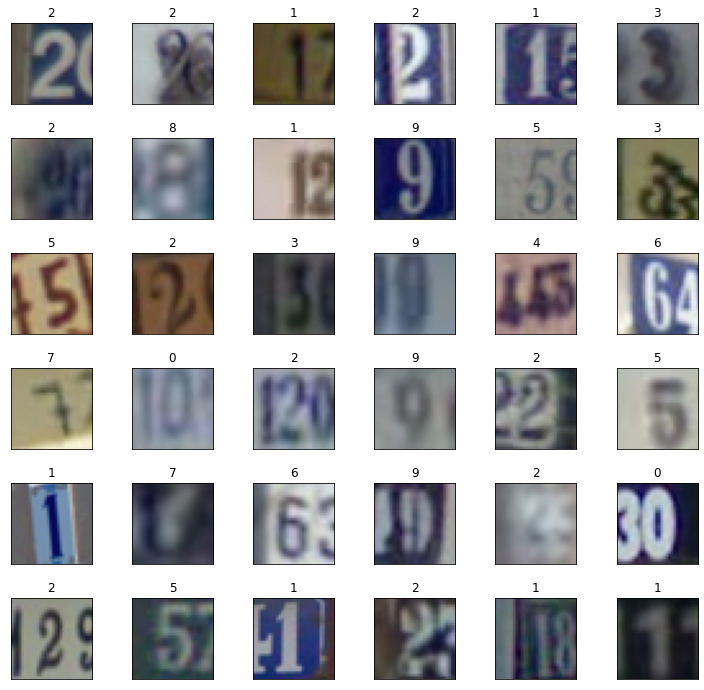

In [6]:
# Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.

plt.figure(figsize=(10,10))
random.seed(228)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.tight_layout()
    index = random.randint(0, len(train_data))
    plt.imshow(train_data[index])
    label = train_label[index,0] if train_label[index,0]!=10 else 0
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
plt.show()
    

In [7]:
# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. Hint: retain the channel dimension, which will now have size 1.
    
train_data = np.mean(train_data, axis=3, keepdims=True)/255.0
test_data = np.mean(test_data, axis=3, keepdims=True)/255.0

# print(train_label[50:55])

train_label = np.where(train_label==10, 0, train_label)
test_label = np.where(test_label==10, 0, test_label)
# train_label = np.squeeze(np.where(train_label==10, 0, train_label))
# test_label = np.squeeze(np.where(test_label==10, 0, test_label))

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
# print(train_data[0, 1, 1])
# print(train_label[50:55])

(73257, 32, 32, 1) (73257, 1)
(26032, 32, 32, 1) (26032, 1)


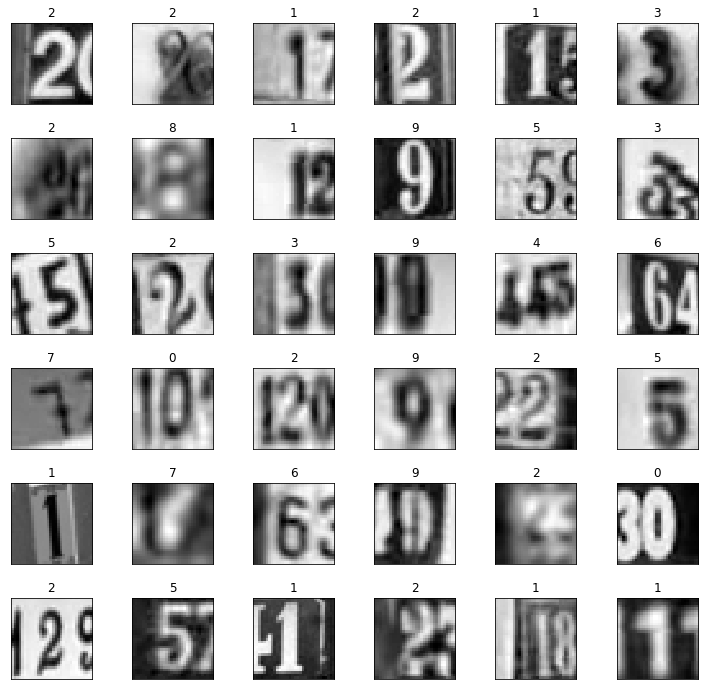

In [8]:
plt.figure(figsize=(10,10))
random.seed(228)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.tight_layout()
    index = random.randint(0, len(train_data))
    plt.imshow(np.squeeze(train_data[index]), cmap='gray', interpolation='none')
    plt.title(train_label[index, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [15]:
from tensorboard.plugins.hparams import api as hp
from absl import app, flags
import shutil

HP_LAYER_COUNT = hp.HParam("layer_count", hp.IntInterval(2, 5))
HP_NUM_UNITS  = hp.HParam("num_units", hp.Discrete([128, 256]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.RealInterval(0.0005, 0.002))

METRIC_ACCURACY = 'accuracy'

!rm -rf logs
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_LAYER_COUNT, HP_NUM_UNITS, HP_LEARNING_RATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )
    
print('-'*25, 'HP_LAYER_COUNT' ,'-'*25)    
for deep_layers in range(HP_LAYER_COUNT.domain.min_value,
                         HP_LAYER_COUNT.domain.max_value):
    print(deep_layers)
    
print('-'*25, 'HP_NUM_UNITS' ,'-'*25)    
for deep_layer_size in HP_NUM_UNITS.domain.values:
    print(deep_layer_size)
    
print('-'*25, 'HP_LEARNING_RATE' ,'-'*25)    
for learning_rate in np.arange(HP_LEARNING_RATE.domain.min_value,
                               HP_LEARNING_RATE.domain.max_value,
                               0.0005):
    print(learning_rate)
    


------------------------- HP_LAYER_COUNT -------------------------
2
3
4
------------------------- HP_NUM_UNITS -------------------------
128
256
------------------------- HP_LEARNING_RATE -------------------------
0.0001
0.0002
0.00030000000000000003


In [16]:
def train_test_model(hparams, epochs):
    model = models.Sequential()
    model.add(layers.Flatten()) 
        
    for _ in range(hparams[HP_LAYER_COUNT]):
        model.add(
            layers.Dense(
                units=hparams[HP_NUM_UNITS],
                activation="relu"
            ))    
    model.add(layers.Dense(10, activation='softmax')) 

    model.compile(optimizer=optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"],
    )
    
    model.fit(train_data, train_label, epochs=epochs)
    _, accuracy = model.evaluate(test_data, test_label)

    return accuracy

def run(run_dir, hparams, epochs):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams, epochs)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)    
    

def run_all(epochs=5):
    session_num = 0

    for num_units in HP_NUM_UNITS.domain.values:
        for lay_count in range(HP_LAYER_COUNT.domain.min_value, HP_LAYER_COUNT.domain.max_value):
            for learning_rate in np.arange(HP_LEARNING_RATE.domain.min_value, 
                                           HP_LEARNING_RATE.domain.max_value,
                                           0.0001):
                hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_LAYER_COUNT: lay_count,
                    HP_LEARNING_RATE: learning_rate,
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run('logs/hparam_tuning/' + run_name, hparams, epochs)
                session_num += 1    

In [17]:
run_all()

--- Starting trial: run-0
{'num_units': 128, 'layer_count': 2, 'learning_rate': 0.0001}
Epoch 1/5
2290/2290 [==============================] - 4s 2ms/step - loss: 2.0968 - accuracy: 0.2658
Epoch 2/5
2290/2290 [==============================] - 4s 2ms/step - loss: 1.5990 - accuracy: 0.4816
Epoch 3/5
2290/2290 [==============================] - 4s 2ms/step - loss: 1.3567 - accuracy: 0.5800
Epoch 4/5
2290/2290 [==============================] - 4s 2ms/step - loss: 1.2273 - accuracy: 0.6287
Epoch 5/5
814/814 [==============================] - 1s 1ms/step - loss: 1.2669 - accuracy: 0.6099
--- Starting trial: run-1
{'num_units': 128, 'layer_count': 2, 'learning_rate': 0.0002}
Epoch 1/5
2290/2290 [==============================] - 4s 2ms/step - loss: 1.9822 - accuracy: 0.3112
Epoch 2/5
2290/2290 [==============================] - 4s 2ms/step - loss: 1.4095 - accuracy: 0.5533
Epoch 3/5
2290/2290 [==============================] - 4s 2ms/step - loss: 1.2027 - accuracy: 0.6323
Epoch 4/5
2290/229

In [ ]:
! tensorboard --logdir logs/hparam_tuning --bind_all

2020-11-23 04:51:04.447120: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorBoard 2.3.0 at http://b7fbff9a047a:6006/ (Press CTRL+C to quit)


打开 http://15.15.166.35:16006/